# NLU Project

## Importing the necessary libraries

In [93]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from typing import Tuple, List, Optional, Union, Tuple, Text
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import seaborn as sns
import datetime
from itertools import permutations
import heapq
import csv
from string import punctuation
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
stopwords.words('english')
from nltk.stem import WordNetLemmatizer
import random
from collections import Counter
from nltk.tokenize import word_tokenize

# nltk.download()

pd.options.display.max_colwidth = 500
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

## Setting up the project environment

In [94]:
# .csv configuration
encoding = "utf-8"
delimiter = None
working_directory_path = "./"

## Loading the question dataset

In [95]:
pure_data = working_directory_path + "question_tag.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [96]:
df.shape

(163194, 11)

## Filtering the specific tags

In [97]:
def tag_filter(pref_tags: List, tags: str) -> bool:
    regex = ""
    for tag in pref_tags:
        regex += '(?=.*\\b'+ tag +'([+-]?([0-9]*[.])?[0-9]*)\\b)'
    regex = r"^" + regex + ".*$"
    tags = tags.strip().lower()
    match_result = re.match(regex, tags, re.MULTILINE | re.IGNORECASE)
    if match_result is None:
        return 0
    else:
        return 1

In [98]:
tags = ["scikit-learn", "python"]
df['HasPreferableTags'] = df['Tags'].apply(lambda row_tags: tag_filter(tags, row_tags))
df_sklearn_tags = df[df['HasPreferableTags']==True]
df_sklearn_tags = df_sklearn_tags.drop(['HasPreferableTags'], axis='columns')

In [99]:
tags = ["keras", "python"]
df['HasPreferableTags'] = df['Tags'].apply(lambda row_tags: tag_filter(tags, row_tags))
df_keras_tags = df[df['HasPreferableTags']==True]
df_keras_tags = df_keras_tags.drop(['HasPreferableTags'], axis='columns')

In [100]:
tags = ["pytorch", "python"]
df['HasPreferableTags'] = df['Tags'].apply(lambda row_tags: tag_filter(tags, row_tags))
df_PT_tags = df[df['HasPreferableTags']==True]
df_PT_tags = df_PT_tags.drop(['HasPreferableTags'], axis='columns')

In [101]:
tags = ["tensorflow", "python"]
df['HasPreferableTags'] = df['Tags'].apply(lambda row_tags: tag_filter(tags, row_tags))
df_TF_tags = df[df['HasPreferableTags']==True]
df_TF_tags = df_TF_tags.drop(['HasPreferableTags'], axis='columns')

In [102]:
df_tags = pd.concat([df_sklearn_tags, df_keras_tags, df_TF_tags, df_PT_tags])

## Checking duplication rows in our DF

In [103]:
df_tags.shape

(124888, 11)

In [104]:
df_tags.drop_duplicates(["Id", "PostTypeId", "AcceptedAnswerId", "ViewCount", "AnswerCount", "CommentCount", "Score", "Title", 'Body', 'Tags'], ignore_index=False, inplace=True)
df_tags = df_tags.reset_index(drop=True)

In [105]:
df_tags.shape

(71328, 11)

## Extracting the code parts from body

In [106]:
def extract_code_blocks(body: str, _id: int) -> List:  
    regex = r"(<pre>|(<pre((.*?)|(\n)*)*><code>))((.*?)|(\n)*)*(<\/code><\/pre>|</pre></code>|</pre>)"
    # regex = r"<pre><code>((.*?)|(\n)*)*(<\/code><\/pre>|</pre></code>)"
    matches = re.finditer(regex, body, re.MULTILINE | re.IGNORECASE)
    result = []
    
    if _id in [47173]:   # <~~~~ Bugy post
        return result
    
    try:
        for matchNum, match in enumerate(matches):
            code = match.group()
            code = code.replace("<pre><code>", "")
            code = code.replace("</pre></code>", "")
            code = code.replace("</code></pre>", "")
            result.append(code)
    except:
        print("Error(1): ", _id)
        print(body)
        return None

    return result

In [107]:
df_tags['Code'] = df_tags.apply(lambda row: extract_code_blocks(row.Body, row.name), axis=1)

## Finding the number of questions that have a code or not

In [108]:
count__question_w_code  = 0
count__question_wo_code = 0
count__num_codes = 0

def counting_w_or_wo_code(row_code: List) -> bool:
    global count__question_w_code, count__question_wo_code, count__num_codes
    
    if row_code:
        count__question_w_code = count__question_w_code + 1
        count__num_codes += len(row_code)
        return True
    else:
        count__question_wo_code = count__question_wo_code + 1
        return False

In [109]:
df_tags['Has_code'] = df_tags['Code'].apply(lambda row_code: counting_w_or_wo_code(row_code))

In [110]:
print(f"We have {df_tags.shape[0]} records in our DB, including {count__question_w_code} posts that have code part in themselve and {count__question_wo_code} w/o any code part.")

We have 71328 records in our DB, including 58580 posts that have code part in themselve and 12748 w/o any code part.


In [111]:
print(f"We have {count__num_codes} number of code blocks including stacktrace, snippet code, error message.")

We have 126459 number of code blocks including stacktrace, snippet code, error message.


## Finding the Error Message inside stack traces

In [112]:
count_number_exact_st = 0

def extract_pathnames_from_code_column(code_sec: List) -> Tuple[str, List]: 
    global count_number_exact_st
    
    try:
        result_post_file_names = []
        OS_flag = None
        
        for code in code_sec:
            regex_unix    = r"[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\W+([a-zA-Z_$][a-zA-Z_$0-9]*)"
            regex_windows = r"(([a-zA-Z]:)|\~)\\?([^\<\>\:\"\\\/\/\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\W+([a-zA-Z_$][a-zA-Z_$0-9]*)"
            pattern_unix  = re.compile(regex_unix)
            pattern_windows  = re.compile(regex_windows)
            
            if pattern_unix.search(code):
                OS_flag = "unix"
                break
            elif pattern_windows.search(code):
                OS_flag = "windows"
                break
        
        if OS_flag == "unix":
            for code in code_sec:
                regex = r"[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\W+([a-zA-Z_$][a-zA-Z_$0-9]*)"
                code = code.replace("\\n", "\n")
                code = code.replace('&lt;', '<')
                code = code.replace('&gt;', '>')
                code = code.replace('&quot;', '"')
                matches = re.finditer(regex, code, re.MULTILINE)
                file_names_for_each_code_part = []

                for matchNum, match in enumerate(matches, start=1):
                    file_names_for_each_code_part.append((match.groups()[1].strip(), match.groups()[4].strip()))              
                
                if file_names_for_each_code_part:  # Ignore the empty list
                    count_number_exact_st += 1
                    result_post_file_names.append(file_names_for_each_code_part)
                    
        elif OS_flag == "windows":
            for code in code_sec:
                regex = r"(([a-zA-Z]:)|\~)\\?([^\<\>\:\"\\\/\/\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)[^\d\n]+(\d*)\W*in\W+([a-zA-Z_$][a-zA-Z_$0-9]*)"
                code = code.replace('&lt;', '<')
                code = code.replace('&gt;', '>')
                code = code.replace('&quot;', '"')
                matches = re.finditer(regex, code, re.MULTILINE)                            
                file_names_for_each_code_part = []

                for matchNum, match in enumerate(matches, start=1):
                    file_names_for_each_code_part.append((match.groups()[3].strip(), match.groups()[6].strip()))
                    result_post_file_names.append(file_names_for_each_code_part)   
                
                if file_names_for_each_code_part:  # Ignore the empty list
                    count_number_exact_st += 1
                    result_post_file_names.append(file_names_for_each_code_part)
    except:
        print("Error(2): ", code_sec)
        return None, None

    return OS_flag, result_post_file_names

In [113]:
# df_tags[df_tags["Has_code"] == True]["Title"].head(50)

In [114]:
df_tags['Buggy_tuples'] = df_tags['Code'].apply(lambda row_code_ex: extract_pathnames_from_code_column(row_code_ex))

In [115]:
def create_has_trace_col(cal_tuple) -> bool:
    if cal_tuple[0] == "windows" or cal_tuple[0] == "unix":
        return True
    elif cal_tuple[0] is None:
        return False
    else:
        print("Error!")

In [116]:
df_tags['Has_trace'] = df_tags['Buggy_tuples'].apply(lambda cell_tuple: create_has_trace_col(cell_tuple))

In [117]:
df_tags_stack_trace = df_tags[df_tags['Has_trace'] == True]

In [118]:
print(f"We Found {count_number_exact_st} individual stack traces. In addition, we have {df_tags_stack_trace.shape[0]} number of posts that have stack traces.")

We Found 9403 individual stack traces. In addition, we have 8958 number of posts that have stack traces.


In [119]:
# df_tags_stack_trace[["Id", "Title", "Code"]].to_csv('./tmp.csv', sep='\n', encoding='utf-8')

In [120]:
lst_id_has_trace_wo_err_mess = []
c_has_trace   = 0
c_has_err_mes = 0

def extract_error_messages(id: int, Has_code: bool, Has_trace: bool, code_sec: List) -> Optional[List]:
    try:
        global lst_id_has_trace_wo_err_mess, c_has_trace, c_has_err_mes
        
        if Has_trace: c_has_trace += 1
        # if not (Has_trace and Has_code): print(f"Error (2): It's not possiable. Has_code: {Has_code}, Has_trace: {Has_trace}")
            
        result_total = []
        
        for code in code_sec:
            # regex = r"([A-Z]\w+(Error|Warning|Exception))([^:]*):\s(.*)$"
            # V3
            regex = r"^([A-Z]\w+Error)(\w|\s|\(|\)|\d)*:\s(.*)$"
            # regex = r"([A-Z]\w+Error):\s(.*)$"
            code = code.replace("\\n", "\n")
            code = code.replace('&lt;', '<')
            code = code.replace('&gt;', '>')
            code = code.replace('&quot;', '"')
            matches = re.finditer(regex, code, re.MULTILINE)
            result_each_code_part = []

            for matchNum, match in enumerate(matches, start=1):
                result_each_code_part.append((match.groups()[0].strip(), match.groups()[2].strip()))
            
            if result_each_code_part:   # Ignore the empty list
                result_total.append(result_each_code_part)

        if (not result_total) and Has_trace: 
            # print("Warning!: We have to check this is ID: ", id)
            lst_id_has_trace_wo_err_mess.append(id)
        
        if result_total:
            c_has_err_mes += len(result_total)
            
        return result_total
    
    except:
        print("Error(1): ", id)
        print(code_sec)
        return None

In [121]:
# print(len(lst_id_has_trace_wo_err_mess))
# print(random.choices(lst_id_has_trace_wo_err_mess, k=5))
# # [29653321, 31428581, 36245192, 23484532, 22974521] all these ids checked and ok!
# df_tags[df_tags["Id"] == 36255281]

In [122]:
# df_tags_stack_trace.iloc[9][:]
# df_tags_stack_trace.apply(lambda row: extract_error_messages(row.Id, row.Has_code, row.Has_trace, row.Code), axis=1)

df_tags_stack_trace["Err_msg"] = df_tags_stack_trace.apply(lambda row: extract_error_messages(row.Id, row.Has_code, row.Has_trace, row.Code), axis=1)

In [123]:
print(f"We captured {c_has_trace} stack traces, however {c_has_trace-len(lst_id_has_trace_wo_err_mess)} stacktraces had the one type of error messages. I mean, {len(lst_id_has_trace_wo_err_mess)} stack traces didn't have any error message.")

We captured 8958 stack traces, however 7475 stacktraces had the one type of error messages. I mean, 1483 stack traces didn't have any error message.


In [124]:
df_msg = df_tags_stack_trace[df_tags_stack_trace['Err_msg'].map(lambda err_msg_list: len(err_msg_list)) > 0]
df_msg.reset_index(drop=True, inplace=True)

In [125]:
df_msg.shape

(7475, 16)

In [126]:
df_msg['Err_msg'].to_csv('./err_msgs.csv', encoding='utf-8')

In [127]:
df_msg[df_msg['Err_msg'].map(lambda err_msg_list: len(err_msg_list)) > 0].shape

(7475, 16)

In [128]:
df_result = pd.DataFrame(columns=['Title', 'ErrorType', 'ErrorMessage'])

In [129]:
def message_extractor(msg_title: str, msg_list: list) -> None:
    global df_result
    
    for message in msg_list:
        df_result = df_result.append({'Title': msg_title, 'ErrorType': message[0][0], 'ErrorMessage': message[0][1]}, ignore_index=True)

In [130]:
_ = df_msg.apply(lambda row: message_extractor(row.Title, row.Err_msg), axis=1)

In [131]:
df_result.shape

(8271, 3)

In [132]:
df_result.head()

,Title,ErrorType,ErrorMessage
0,Python 2.7/ Scikit learn 0.17 Linear Regression error: ValueError: Found arrays with inconsistent numbers of samples: [ 1 343],ValueError,Found arrays with inconsistent numbers of samples: [ 1 343]>>>
1,LASSO TypeError: len() of unsized object,TypeError,len() of unsized object
2,ValueError: Dataset with data_id 554 not found,ValueError,Dataset with data_id 554 not found.
3,how we can create our tagged corpus,TypeError,expected string or buffer
4,"Python, finding error in near symmetric matrix created by df.pivot",ValueError,Array must be symmetric


## Tokenization

In the preprocessing section, we drop duplicate observations from the data frame and make sure all data have a string format, furthermore prepare the data frame for the next step.

In [133]:
# Make sure all the elements are string
df_result = df_result.applymap(str)

# Notice: strip() function will remove leading and trailing whitespaces.
df_result['ErrorType'] = df_result['ErrorType'].apply(lambda x: x.strip())

In [134]:
# Extract message length
df_result['First_Msg_length'] = df_result['ErrorMessage'].apply(lambda x: len(x))

In [135]:
# I used the code that coded here: https://www.kaggle.com/aditiani/analyzing-chatbot

contractions_dict = {     
"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
"could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
"don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not",
"he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I had", "I'd've": "I would have",
"I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "isn't": "is not", "it'd": "it had",
"it'd've": "it would have", "it'll": "it will", "it'll've": "iit will have", "it's": "it is", "let's": "let us",
"ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
"must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
"o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
"sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she had", "she'd've": "she would have", "she'll": "she will",
"she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not",
"shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that had", "that'd've": "that would have",
"that's": "that is", "there'd": "there had", "there'd've": "there would have", "there's": "there is", "they'd": "they had",
"they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are",
"they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we had", "we'd've": "we would have",
"we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
"what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have",
"when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
"who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
"why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
"wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
"y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you had",
"you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"
}

def expand_contraction(text, contraction_dict):
    contraction_pattern = re.compile('({})'.format('|'.join(contraction_dict.keys())), flags= re.IGNORECASE | re.DOTALL)
    
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_dict.get(match) \
            if contraction_dict.get(match) \
            else contraction_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        
        return expanded_contraction
        
    expanded_text = contraction_pattern.sub(expand_match, text)
    expanded_text = re.sub("'","", expanded_text)
    
    return expanded_text

def main_contraction(text: str) -> str:
    text = expand_contraction(text, contractions_dict)
    
    return text

In [136]:
def to_lower(text: str) -> str:
    return text.lower()

In [137]:
def remove_number(text: str) -> str:
    output = ''.join(c for c in text if not c.isdigit())
    return output

In [138]:
def to_strip(text: str) -> str:
    # return " ".join([c for c in text.split() if len(c)>2])    
    return " ".join([c for c in text.split()])

In [139]:
def remove_char(text: str) -> str:
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    return text

In [140]:
def remove_duplicate(text: str) -> str:
    text = re.sub("(.)\\1{2,}", "\\1", text)
    return text

In [141]:
def remove_stopwords(text: str) -> str:
    stop_words = stopwords.words('english')
    return ' '.join(c for c in nltk.word_tokenize(text) if c not in stop_words)

In [142]:
wordnet_lemma = WordNetLemmatizer()

def lemma(text: str) -> str:
    lemmatize_words = [wordnet_lemma.lemmatize(word, 'v') for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    return ' '.join(lemmatize_words)

In [143]:
# Remove the punctuations
def remove_punct(text):
    # return "".join(c for c in text if c not in punctuation)    
    return "".join(c for c in text if c not in punctuation)

In [144]:
# Split identifier names, such as: camelCase, under_scores, dot.notation
def identifier_converter(text: str) -> str:
    text = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', text)
    text = re.sub('__([A-Z])', r'_\1', text)
    text = re.sub('([a-z0-9])([A-Z])', r'\1_\2', text)
    text = re.sub(r"_|\.", " ", text)
    return re.sub(r"\s+", " ", text).lower()

In [145]:
def specific_converter(text: str) -> str:
    text = text.replace("NaN", 'nan')    
    text = text.replace("Kmean", 'kmean')    
    text = text.replace("KMeans", 'kmean')    
    text = text.replace("Kmeans", 'kmean')    
    text = text.replace("pyTorch", 'pytorch')
    text = text.replace("PyTorch", 'pytorch')
    text = text.replace("GiB", 'gib')
    text = text.replace("MiB", 'mib') 
    text = text.replace("TiB", 'tib') 
    return text

In [146]:
def change_punc_space(text: str) -> str:
    for character in punctuation:
        text = text.replace(character, ' ')
    return text

In [147]:
df_result['prep1'] = df_result['ErrorMessage'].apply(to_lower)
df_result['prep2'] = df_result['prep1'].apply(main_contraction)
df_result['prep3'] = df_result['prep2'].apply(remove_number)
df_result['prep4'] = df_result['prep3'].apply(remove_punct)
df_result['prep5'] = df_result['prep4'].apply(to_strip)
df_result['prep6'] = df_result['prep5'].apply(remove_char)
df_result['prep7'] = df_result['prep6'].apply(remove_duplicate)
df_result['prep8'] = df_result['prep7'].apply(remove_stopwords)
df_result['ErrMsgPurified_type_1'] = df_result['prep8'].apply(lemma)
df_result.drop(['prep1', 'prep2', 'prep3', 'prep4', 'prep5', 'prep6', 'prep7', 'prep8'], axis=1, inplace=True)

In [148]:
# Get the frequency of each message type
print(df_result.groupby(['ErrorType'])['ErrorType'].count().reset_index(name='count').sort_values(['count'], ascending=False).nlargest(10, 'count'))
df_result.shape

               ErrorType  count
89            ValueError   2584
76             TypeError   1329
26           ImportError   1084
3         AttributeError    890
31  InvalidArgumentError    423
69          RuntimeError    416
28            IndexError    206
36              KeyError    191
45   ModuleNotFoundError    163
52               OSError    129


(8271, 5)

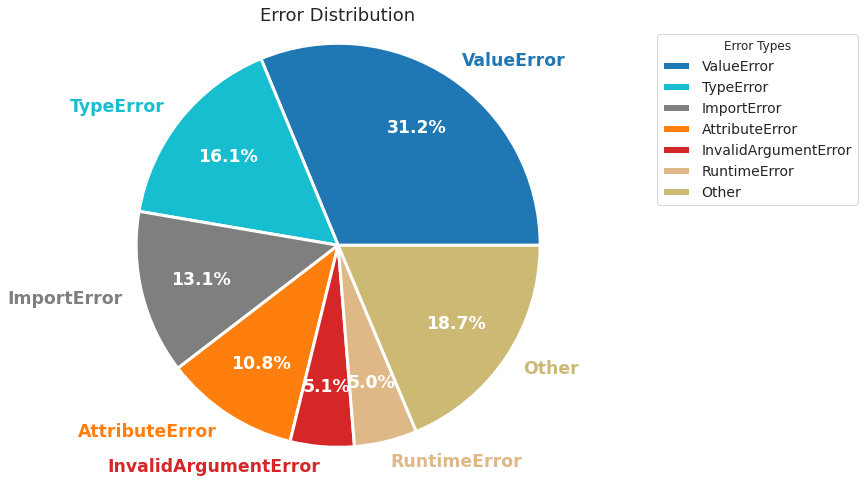

In [149]:
TOP = 6
df = df_result.groupby(['ErrorType'])['ErrorType'].count().reset_index(name='count').sort_values(['count'], ascending=False)
df2 = df.iloc[:TOP]
df2 = df2.append({'ErrorType': 'Other', 'count': df['count'].iloc[TOP:].sum()}, ignore_index=True)
colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red', 'burlywood', 'y']

fig, ax = plt.subplots(figsize=(8, 8))

patches, texts, pcts =  ax.pie(df2.set_index('ErrorType')['count'],
                               labels=df2['ErrorType'],
                                autopct='%1.1f%%', 
                                pctdistance=0.7, 
                                labeldistance=1.1, 
                                # textprops={'fontsize': 12},
                                textprops={'size': 'x-large'},
                                colors=colors,
                                wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},)

s = df2.groupby('ErrorType')['count'].sum().map(lambda x : x).sort_values(ascending = False)
labels = [f'{name}, {percentage*100:0.1f}%' for name, percentage in zip(s.index, s / s.sum())]
ax.legend(bbox_to_anchor=(1.2, 1), 
           loc='upper left', 
           # labels=labels,
           title="Error Types",
           # labelcolor=colors,
           fontsize=14)


plt.setp(pcts, color='white', fontweight='bold')
ax.set_title("Error Distribution", fontsize=18)
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    
plt.setp(texts, fontweight=600)

ax.axis('equal')  
# plt.tight_layout()
ax.figure.savefig('piechart.png', bbox_inches='tight')

In [150]:
# Tokenization
# def tokenize(text: str) -> list:
#     split = re.split("\W+", text) 
#     return split
# df_result['Msg_wo_punct_split'] = df_result['Msg_wo_punct'].apply(lambda x: tokenize(x.lower()))

In [151]:
# Drop duplicates from data
bef_reduc = df_result.shape[0]
df_result.drop_duplicates(["Title", "ErrorType", "ErrorMessage"], ignore_index=False, inplace=True)
# df_result.drop_duplicates(["Title", "ErrorType", "ErrorMessage"], ignore_index=False)
aft_reduc = df_result.shape[0]

In [152]:
# Reset index
df_result = df_result.reset_index(drop=True)

In [153]:
print(f"The number of records decresed from {bef_reduc} to {aft_reduc}.")

The number of records decresed from 8271 to 7984.


In [154]:
# df_result[df_result['Msg_length'] < 10]

In [155]:
# Length restriction: We can eliminate the rows that cannot pass the length limitation.
length_threshold = 10  # <~~~ we want to delete rows that have less than 10 characters.
bef_reduc = df_result.shape[0]
df_result = df_result[df_result['First_Msg_length'] > length_threshold]
df_result.reset_index(drop=True, inplace=True)
aft_reduc = df_result.shape[0]

In [156]:
print(f"The number of records decresed from {bef_reduc} to {aft_reduc}.")

The number of records decresed from 7984 to 7823.


In [157]:
# df_result['prep0'] = df_result['ErrorMessage'].apply(change_punc_space)
# df_result['prep1'] = df_result['prep0'].apply(to_lower)
# df_result['prep2'] = df_result['prep1'].apply(main_contraction)
# df_result['prep3'] = df_result['prep2'].apply(remove_number)
# df_result['prep4'] = df_result['prep3'].apply(remove_punct)
# df_result['prep5'] = df_result['prep4'].apply(to_strip)
# df_result['prep6'] = df_result['prep5'].apply(remove_char)
# df_result['prep7'] = df_result['prep6'].apply(remove_duplicate)
# df_result['prep8'] = df_result['prep7'].apply(remove_stopwords)
# df_result['ErrMsgPurified_type_1'] = df_result['prep8'].apply(lemma)
# df_result.drop(['prep0', 'prep1', 'prep2', 'prep3', 'prep4', 'prep5', 'prep6', 'prep7', 'prep8'], axis=1, inplace=True)

In [158]:
df_result['Change_punc_space']      = df_result['ErrorMessage'].apply(change_punc_space)
df_result['Specific_converter']     = df_result['Change_punc_space'].apply(specific_converter)
df_result['Identifier_converter']   = df_result['Specific_converter'].apply(identifier_converter)
df_result['To_lower']               = df_result['Identifier_converter'].apply(to_lower)
df_result['Main_contraction']       = df_result['To_lower'].apply(main_contraction)
df_result['Remove_number']          = df_result['Main_contraction'].apply(remove_number)
df_result['Remove_punct']           = df_result['Remove_number'].apply(remove_punct)
df_result['To_strip']               = df_result['Remove_punct'].apply(to_strip)
df_result['Remove_char']            = df_result['To_strip'].apply(remove_char)
df_result['Remove_duplicate']       = df_result['Remove_char'].apply(remove_duplicate)
df_result['Remove_stopwords']       = df_result['Remove_duplicate'].apply(remove_stopwords)
df_result['Lemma']                  = df_result['Remove_stopwords'].apply(lemma)
df_result['ErrMsgPurified_type_2']  = df_result['Lemma']

# df_result.drop(['Change_punc_space', 'Specific_converter', 'Identifier_converter', 'To_lower', 'Main_contraction', 'Remove_number', 'Remove_punct', 'To_strip', 'Remove_char', 'Remove_duplicate', 'Remove_stopwords', 'Lemma'], axis=1, inplace=True)

In [159]:
df_result.columns

Index(['Title', 'ErrorType', 'ErrorMessage', 'First_Msg_length',
       'ErrMsgPurified_type_1', 'Change_punc_space', 'Specific_converter',
       'Identifier_converter', 'To_lower', 'Main_contraction', 'Remove_number',
       'Remove_punct', 'To_strip', 'Remove_char', 'Remove_duplicate',
       'Remove_stopwords', 'Lemma', 'ErrMsgPurified_type_2'],
      dtype='object')

In [160]:
# df_result[["Title", "ErrorMessage","ErrMsgPurified_w_space_ident_conv"]].tail(100)
# df_result[["ErrorMessage","Lemma"]].iloc[2]
# df_result.iloc[23]
# df_result[["ErrorMessage","Lemma"]].tail(100)
# df_result[['Change_punc_space', 'Specific_converter', 'Identifier_converter', 'To_lower', 'Main_contraction', 'Remove_number', 'Remove_punct', 'To_strip', 'Remove_char', 'Remove_duplicate', 'Remove_stopwords', 'Lemma']].tail(100)

In [161]:
# df_result[["ErrorMessage", "ErrMsgPurified_w_space"]].sample(10)

In [162]:
# Extract message length
df_result['Msg_length_type_1'] = df_result['ErrMsgPurified_type_1'].apply(lambda x: len(x))
df_result['Msg_length_type_2'] = df_result['ErrMsgPurified_type_2'].apply(lambda x: len(x))
df_result['Num_words_type_1'] = df_result['ErrMsgPurified_type_1'].str.split().apply(len)
df_result['Num_words_type_2'] = df_result['ErrMsgPurified_type_2'].str.split().apply(len)

In [163]:
# df_result.sample(10)

In [164]:
df_result.columns

Index(['Title', 'ErrorType', 'ErrorMessage', 'First_Msg_length',
       'ErrMsgPurified_type_1', 'Change_punc_space', 'Specific_converter',
       'Identifier_converter', 'To_lower', 'Main_contraction', 'Remove_number',
       'Remove_punct', 'To_strip', 'Remove_char', 'Remove_duplicate',
       'Remove_stopwords', 'Lemma', 'ErrMsgPurified_type_2',
       'Msg_length_type_1', 'Msg_length_type_2', 'Num_words_type_1',
       'Num_words_type_2'],
      dtype='object')

In [165]:
df_result[[ "Title", 'ErrorType', 'ErrorMessage', 'ErrMsgPurified_type_2','Change_punc_space', 'Specific_converter', 'Identifier_converter',
       'To_lower', 'Main_contraction', 'Remove_number', 'Remove_punct',
       'To_strip', 'Remove_char', 'Remove_duplicate', 'Remove_stopwords',
       'Lemma']][df_result['Msg_length_type_2'] < 10]

,Title,ErrorType,ErrorMessage,ErrMsgPurified_type_2,Change_punc_space,Specific_converter,Identifier_converter,To_lower,Main_contraction,Remove_number,Remove_punct,To_strip,Remove_char,Remove_duplicate,Remove_stopwords,Lemma
44,Tensorflow | ValueError: No gradients provided for any variable,ValueError,in user code:,user code,in user code,in user code,in user code,in user code,in user code,in user code,in user code,in user code,in user code,in user code,user code,user code
73,Don't understand this AttributeError with inverse of a matrix,AttributeError,I not found,find,I not found,I not found,i not found,i not found,i not found,i not found,i not found,i not found,i not found,i not found,found,find
207,How to Cross Validate SVM with Custom Kernel Function in sklearn,TypeError,"'(array([[ 23],",array,array 23,array 23,array 23,array 23,array 23,array,array,array,array,array,array,array
294,Label Propagation - Array is too big,ValueError,array is too big.,array big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array big,array big
379,Error while passing parameters for DecisionTreeClassifier,KeyError,'max_depth=100',max depth,max depth 100,max depth 100,max depth 100,max depth 100,max depth 100,max depth,max depth,max depth,max depth,max depth,max depth,max depth
473,"Gaussian process algorithm erroring out, memory issues with numpy?",ValueError,array is too big.,array big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array big,array big
611,"use random forest to classifier review, but hat key error?",KeyError,'sentiment',sentiment,sentiment,sentiment,sentiment,sentiment,sentiment,sentiment,sentiment,sentiment,sentiment,sentiment,sentiment,sentiment
759,drop function returning KeyError | Pandas,KeyError,'[0 0 0 ... 1 0 1] not found in axis',find axis,0 0 0 1 0 1 not found in axis,0 0 0 1 0 1 not found in axis,0 0 0 1 0 1 not found in axis,0 0 0 1 0 1 not found in axis,0 0 0 1 0 1 not found in axis,not found in axis,not found in axis,not found in axis,not found in axis,not found in axis,found axis,find axis
831,Weird ValueError in KNeighborsClassifier score,ValueError,kth(=2) out of bounds (1),kth bound,kth 2 out of bounds 1,kth 2 out of bounds 1,kth 2 out of bounds 1,kth 2 out of bounds 1,kth 2 out of bounds 1,kth out of bounds,kth out of bounds,kth out of bounds,kth out of bounds,kth out of bounds,kth bounds,kth bound
1062,Sklearn - Cannot use encoded data in Random forest classifier,ValueError,array is too big.,array big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array is too big,array big,array big


In [166]:
df_result.shape

(7823, 22)

In [167]:
df_result[["ErrMsgPurified_type_2"]].to_csv('./DS_OCTIS/output_type_2_wo_shuffle.csv', index=False, header=False)
df_result[["ErrorType"]].to_csv('./DS_OCTIS/output_type_2_label_wo_shuffle.csv', index=False, header=False)

In [168]:
df_result.shape

(7823, 22)

In [169]:
df_result[["Title", "ErrorMessage", "ErrorType", "ErrMsgPurified_type_2"]].to_csv('./DS_OCTIS/Prof_Li.csv', index=False, header=False)


In [170]:
df_result[["Title", "ErrorMessage", "ErrMsgPurified_type_2"]].tail(1)

,Title,ErrorMessage,ErrMsgPurified_type_2
7822,How to get around in place operation error if index leaf variable for gradient update?,a leaf Variable that requires grad has been used in an in-place operation.,leaf variable require grad use place operation


In [171]:
df_result[df_result['ErrorType'].str.contains(r'YellowbrickValueError', na=True)]

,Title,ErrorType,ErrorMessage,First_Msg_length,ErrMsgPurified_type_1,Change_punc_space,Specific_converter,Identifier_converter,To_lower,Main_contraction,Remove_number,Remove_punct,To_strip,Remove_char,Remove_duplicate,Remove_stopwords,Lemma,ErrMsgPurified_type_2,Msg_length_type_1,Msg_length_type_2,Num_words_type_1,Num_words_type_2
1263,yellowbrick prediction-error plot: getting error at score method,YellowbrickValueError,"y must be a (1,) dimensional array not (610, 1)",47,must dimensional array,y must be a 1 dimensional array not 610 1,y must be a 1 dimensional array not 610 1,y must be a 1 dimensional array not 610 1,y must be a 1 dimensional array not 610 1,y must be a 1 dimensional array not 610 1,y must be a dimensional array not,y must be a dimensional array not,y must be a dimensional array not,y must be a dimensional array not,y must be a dimensional array not,must dimensional array,must dimensional array,must dimensional array,22,22,3,3


In [172]:
df_result.columns

Index(['Title', 'ErrorType', 'ErrorMessage', 'First_Msg_length',
       'ErrMsgPurified_type_1', 'Change_punc_space', 'Specific_converter',
       'Identifier_converter', 'To_lower', 'Main_contraction', 'Remove_number',
       'Remove_punct', 'To_strip', 'Remove_char', 'Remove_duplicate',
       'Remove_stopwords', 'Lemma', 'ErrMsgPurified_type_2',
       'Msg_length_type_1', 'Msg_length_type_2', 'Num_words_type_1',
       'Num_words_type_2'],
      dtype='object')

### Statistical information about DB

In [198]:
df_result.describe()

,First_Msg_length,Msg_length_type_1,Msg_length_type_2,Num_words_type_1,Num_words_type_2
count,7823.000000,7823.000000,7823.000000,7823.000000,7823.000000
mean,72.170267,48.017512,49.293110,6.013166,7.733223
std,78.069973,46.059235,49.654012,4.489991,8.162504
min,11.000000,0.000000,0.000000,0.000000,0.000000
25%,38.000000,26.000000,26.000000,4.000000,4.000000
50%,55.000000,38.000000,39.000000,5.000000,6.000000
75%,87.000000,57.000000,57.000000,7.000000,9.000000
max,3229.000000,1588.000000,1813.000000,116.000000,333.000000


In [174]:
df_result.shape

(7823, 22)

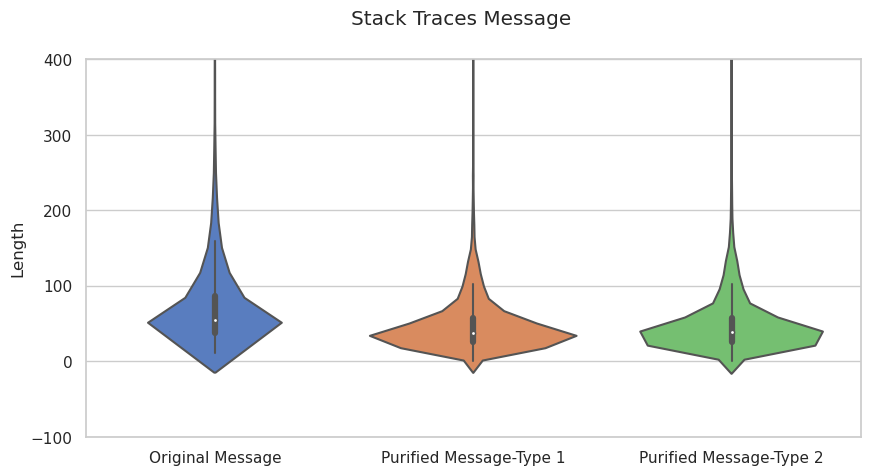

In [175]:
df_1 = pd.DataFrame(columns=['Message Types', 'Length'])
df_1['Length'] = df_result['First_Msg_length']
df_1['Message Types'] = df_1['Message Types'].apply(lambda x: "Original Message")

df_2 = pd.DataFrame(columns=['Message Types', 'Length'])
df_2['Length'] = df_result['Msg_length_type_1']
df_2['Message Types'] = df_2['Message Types'].apply(lambda x: "Purified Message-Type 1")

df_3 = pd.DataFrame(columns=['Message Types', 'Length'])
df_3['Length'] = df_result['Msg_length_type_2']
df_3['Message Types'] = df_3['Message Types'].apply(lambda x: "Purified Message-Type 2")

# result = pd.concat([df_1])
result = pd.concat([df_1, df_2, df_3])

fig = plt.figure(figsize=(10, 5), dpi=100)

sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.violinplot(x=result["Message Types"], y=result["Length"], data=tips, palette="muted")

ax.set(xlabel=None)
# plt.tick_params(bottom=True)  # remove the ticks

plt.ylim(-100,400)

fig.suptitle('Stack Traces Message')
ax.figure.savefig('piechart.png', bbox_inches='tight')

plt.show()

## OCTIS Framework: https://github.com/MIND-Lab/OCTIS

### Create a vocabulary file

In [176]:
tokenized_sents_type_1 = [word_tokenize(i) for i in df_result["ErrMsgPurified_type_1"]]
tokenized_sents_type_2 = [word_tokenize(i) for i in df_result["ErrMsgPurified_type_2"]]

In [177]:
flattened_type_1 = []
for sublist in tokenized_sents_type_1:
    for val in sublist:
        flattened_type_1.append(val)
print(len(flattened_type_1))

flattened_type_2 = []
for sublist in tokenized_sents_type_2:
    for val in sublist:
        flattened_type_2.append(val)
print(len(flattened_type_2))

47041
60497


In [178]:
# vocab_dict = dict(Counter(flattened))
vocab_dict_type_1 = Counter(flattened_type_1)
vocab_dict_type_2 = Counter(flattened_type_2)

In [179]:
print(len(vocab_dict_type_1.keys()))
print(vocab_dict_type_1.most_common(10))

4640
[('shape', 1565), ('object', 1102), ('input', 922), ('array', 904), ('module', 839), ('attribute', 817), ('expect', 815), ('get', 740), ('name', 739), ('tensor', 737)]


In [180]:
vocab_set_type_1 = set(flattened_type_1)
vocab_set_type_2 = set(flattened_type_2)

vocab_set_type_1 = list(vocab_set_type_1)
vocab_set_type_2 = list(vocab_set_type_2)

vocab_set_type_1.sort()
vocab_set_type_2.sort()

# for item in flattened:
#     if not item in vocab:
#         vocab.append(item)
print(len(vocab_set_type_2))

3233


In [181]:
with open("/home-students/amghad/DS_OCTIS/vocabulary_type_1.txt", "w") as f:
    for item in vocab_set_type_1:
        f.write(item + "\n")

In [182]:
with open("/home-students/amghad/DS_OCTIS/vocabulary_type_2.txt", "w") as f:
    for item in vocab_set_type_2:
        f.write(item + "\n")

### Create a corpus file

Shuffle data 

In [183]:
df_result_shuffle = df_result.copy()

In [184]:
np.random.seed(42)
df_result_shuffle = df_result.iloc[np.random.permutation(len(df_result))]
df_result_shuffle.reset_index(drop=True, inplace=True)

In [185]:
df_result_shuffle.columns

Index(['Title', 'ErrorType', 'ErrorMessage', 'First_Msg_length',
       'ErrMsgPurified_type_1', 'Change_punc_space', 'Specific_converter',
       'Identifier_converter', 'To_lower', 'Main_contraction', 'Remove_number',
       'Remove_punct', 'To_strip', 'Remove_char', 'Remove_duplicate',
       'Remove_stopwords', 'Lemma', 'ErrMsgPurified_type_2',
       'Msg_length_type_1', 'Msg_length_type_2', 'Num_words_type_1',
       'Num_words_type_2'],
      dtype='object')

In [186]:
# df_result_shuffle["ErrMsgPurified_type_1"].to_csv('./DS_OCTIS/corpus_type_1.tsv', sep='\t', index=False)
df_result_shuffle["ErrMsgPurified_type_2"].to_csv('./DS_OCTIS/corpus.tsv', sep='\t', index=False, header=False)

In [187]:
df_result_shuffle[["ErrMsgPurified_type_2"]].to_csv('./DS_OCTIS/output_type_2_w_shuffle.csv', index=False, header=False)
df_result_shuffle[["ErrorType"]].to_csv('./DS_OCTIS/output_type_2_label_w_shuffle.csv', index=False, header=False)

Create a Train, Dev, test Data

In [188]:
train_per = 0.8
val_per   = 0.1
test_per  = 0.1

In [189]:
msk_1 = np.random.rand(len(df_result_shuffle)) < train_per

In [190]:
len(df_result_shuffle)

7823

In [191]:
train_df = df_result_shuffle[msk_1]
train_df["Label"] = "train"

In [192]:
test_val_df = df_result_shuffle[~msk_1]
msk_2 = np.random.rand(len(test_val_df)) < val_per

In [193]:
val_df = test_val_df[msk_2]
val_df["Label"] = "val"

In [194]:
test_df = test_val_df[~msk_2]
test_df["Label"] = "test"

In [195]:
len(df_result_shuffle) == len(train_df) + len(val_df) + len(test_df)

True

In [196]:
octis_corpus = pd.concat([train_df, val_df, test_df])
octis_corpus[["ErrMsgPurified_type_2", "Label"]].to_csv('./DS_OCTIS/corpus.tsv', sep='\t', index=False, header=False)
octis_corpus[["ErrMsgPurified_type_2"]].to_csv('./DS_OCTIS/preproc.txt', index=False, header=False)

### Load a Custom Dataset 

Make sure that the dataset is in the following format: </br>
corpus file: a .tsv file (tab-separated) that contains up to three columns, i.e. the document, the partitition, and the label associated to the document (optional).</br>
vocabulary: a .txt file where each line represents a word of the vocabulary</br>
The partition can be "train" for the training partition, "test" for testing partition, or "val" for the validation partition. An example of dataset can be found here: sample_dataset.</br>

In [197]:
from octis.dataset.dataset import Dataset
dataset = Dataset()
dataset.load_custom_dataset_from_folder("/home-students/amghad/DS_OCTIS/hello_dataset")

Exception: error in loading the dataset:/home-students/amghad/DS_OCTIS/hello_dataset

In [ ]:
from octis.models.LDA import LDA
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

In [ ]:
model = LDA(num_topics=20, alpha=0.1)

In [ ]:
# Train the model using default partitioning choice 
output = model.train_model(dataset)

print(*list(output.keys()), sep="\n") # Print the output identifiers

In [ ]:
from octis.models.CTM import CTM
from octis.dataset.dataset import Dataset
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer
from octis.evaluation_metrics.coherence_metrics import Coherence

In [ ]:
model = CTM(num_topics=10, num_epochs=30, inference_type='zeroshot', bert_model="bert-base-nli-mean-tokens", bert_path="/home-students/amghad/")

In [ ]:
npmi = Coherence(texts=dataset.get_corpus())

In [ ]:
search_space = {"num_layers": Categorical({1, 2, 3}), 
                "num_neurons": Categorical({100, 200, 300}),
                "activation": Categorical({'sigmoid', 'relu', 'softplus'}), 
                "dropout": Real(0.0, 0.95)
}

In [ ]:
optimization_runs=30
model_runs=1

In [ ]:
optimizer=Optimizer()
optimization_result = optimizer.optimize(
    model, dataset, npmi, search_space, number_of_call=optimization_runs, 
    model_runs=model_runs, save_models=True, 
    extra_metrics=None, # to keep track of other metrics
    save_path='/home-students/amghad/DS_OCTIS/hello_dataset/result')